<a href="https://colab.research.google.com/github/alekstoteles/UCB/blob/master/CNN_facial_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for [Facial Keypoints Detection Kaggle Competition](https://www.kaggle.com/c/facial-keypoints-detection/overview/evaluation)

Alexander Müller

## Introduction

The purpose of this project is to predict keypoint positions on face images. The data were obtained from [Facial Keypoints Detection Kaggle Competition](https://www.kaggle.com/c/facial-keypoints-detection/overview/evaluation), which contains 30 facial key points using x and y (e.g. left_eye_center_x, left_eye_center_y). To predict facial keypoints, we use convolutional neural networks (CNN). 

This notebook begins with an exploratory data analysis and presents a baseline of the study. Then, we introduce two CNN models, show the model training procedures and discuss model evaluation. Finally, we discuss the limitations of the study and possible ways to improve the model.      

## Imports & settings

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import pickle
from datetime import datetime
import tensorflow as tf
import keras
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, BatchNormalization, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from keras import optimizers

In [0]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.width = 200

In [0]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

## Data ingestion

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/ML_playground/'

FTRAIN = path + 'data/training.csv'
FTEST = path + 'data/test.csv'
FLOOKUP = path + 'data/IdLookupTable.csv'
FSAMPLE = path + 'data/SampleSubmission.csv'

In [0]:
def load(train=True, drop_missing=True):
    """
    Loads data from FTRAIN if *train* is True, otherwise from FTEST.
    """
    fname = FTRAIN if train else FTEST
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if drop_missing:
      df = df.dropna()  # drop all rows that have missing values in them
    
    # print(df.count())  # prints the number of values for each column

    X = df['Image']/255 # scale pixel values to [0, 1]

    if train:  # only FTRAIN has target columns
        y = df[df.columns[:-1]]
    else:
        y = None

    return X, y

In [0]:
# load data with all cases
X_train, y_train = load(train=True, drop_missing=False)
# X_test, y_test = load(train=False, drop_missing=True) # only needed if submitting to Kaggle

## Exploratory Data Analysis

### Data was imported as pandas dataframe (with the feature vector for each observation / pixel values in one row)

In [0]:
X_train.head(5)

0    [0.9333333333333333, 0.9254901960784314, 0.929...
1    [0.8588235294117647, 0.8431372549019608, 0.8, ...
2    [0.5647058823529412, 0.5568627450980392, 0.623...
3    [0.7568627450980392, 0.7529411764705882, 0.756...
4    [0.5764705882352941, 0.5803921568627451, 0.627...
Name: Image, dtype: object

### Some training examples

In [0]:
y_train.head(10).T.round(2)

,0,1,2,3,4,5,6,7,8,9
left_eye_center_x,66.03,64.33,65.06,65.23,66.73,69.68,64.13,67.47,65.80,64.12
left_eye_center_y,39.00,34.97,34.91,37.26,39.62,39.97,34.29,39.41,34.76,36.74
right_eye_center_x,30.23,29.95,30.90,32.02,32.24,29.18,29.58,29.36,27.48,29.47
right_eye_center_y,36.42,33.45,34.91,37.26,38.04,37.56,33.14,39.62,36.19,38.39
left_eye_inner_corner_x,59.58,58.86,59.41,60.00,58.57,62.86,57.80,59.55,58.65,58.62
left_eye_inner_corner_y,39.65,35.27,36.32,39.13,39.62,40.17,35.15,40.45,37.33,37.84
left_eye_outer_corner_x,73.13,70.72,70.98,72.31,72.52,76.90,69.03,75.59,72.95,71.27
left_eye_outer_corner_y,39.97,36.19,36.32,38.38,39.88,41.17,34.29,40.04,35.90,37.29
right_eye_inner_corner_x,36.36,36.03,37.68,37.62,36.98,36.40,34.76,37.48,36.34,36.34
right_eye_inner_corner_y,37.39,34.36,36.32,38.75,39.09,39.37,33.71,40.45,37.04,39.49


### Descriptive Statistics 

*   Missing data
   * Left/Right eye center, nose tip and mouth center bottom tip have more than 7000 cases
   * The rest of features have fewer than 2300 cases
   * Decided to exclude the cases with missing data for the main study but explored a way to include the cases with missing data. 
*  Range/Outliers 
  *  The standard deviation for each keypoint is relatively small. However, the range of each keypoint is wide by looking at min/max. It indicates that there are varying head poses in the dataset.
  * Given that facial features/viewing angles/positions in images vary greatly, decided not to remove any extreme values to caputre various type of features. 



In [0]:
y_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
left_eye_center_x,7039.0,66.36,3.45,22.76,65.08,66.50,68.02,94.69
left_eye_center_y,7039.0,37.65,3.15,1.62,35.90,37.53,39.26,80.50
right_eye_center_x,7036.0,30.31,3.08,0.69,28.78,30.25,31.77,85.04
right_eye_center_y,7036.0,37.98,3.03,4.09,36.33,37.81,39.57,81.27
left_eye_inner_corner_x,2271.0,59.16,2.69,19.06,58.04,59.30,60.52,84.44
left_eye_inner_corner_y,2271.0,37.94,2.31,27.19,36.63,37.88,39.26,66.56
left_eye_outer_corner_x,2267.0,73.33,3.41,27.57,71.72,73.25,75.02,95.26
left_eye_outer_corner_y,2267.0,37.71,2.88,26.25,36.09,37.64,39.37,64.62
right_eye_inner_corner_x,2268.0,36.65,2.35,5.75,35.51,36.65,37.75,70.71
right_eye_inner_corner_y,2268.0,37.99,2.31,26.25,36.77,37.94,39.19,69.81


 ### Sample images with missing feature values for some entries. We see that boundaries for eyes and mouth are missing and we have some issues with accurate labelling of the facial keypoints 

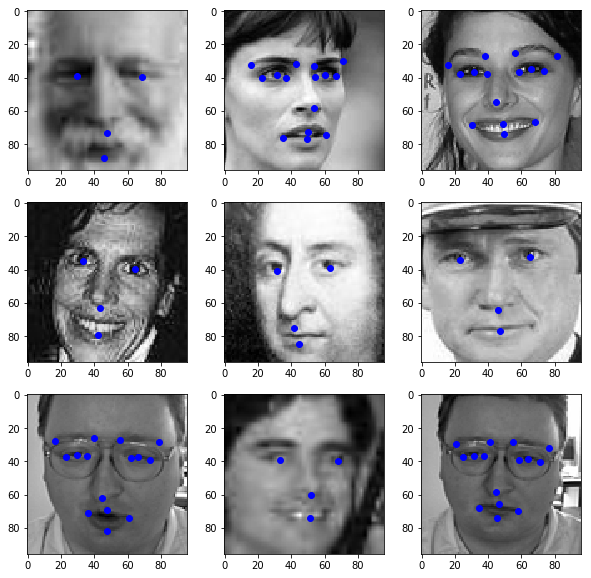

In [0]:
def print_face_example(nrows=3, ncols=3):   
    # select random sample  
    random_sample_ind = np.random.choice(y_train.index, size =(nrows*ncols), replace=False)
    images = X_train[random_sample_ind]    
    keypoints = y_train.loc[random_sample_ind]
    # create a list keypoint columns 
    keypoint_cols = list(y_train.columns)   
    # create plots
    fig, axs = plt.subplots(figsize=(10,10), nrows=nrows, ncols=ncols)
    image_ind = 0
    for i in range(nrows):
        for j in range(ncols):
            xy = keypoints.iloc[image_ind][keypoint_cols].values.reshape((15,2))            
            image = images.iloc[image_ind].reshape(96,96)
            axs[i, j].imshow(image, interpolation="nearest", cmap="gray")
            axs[i, j].plot(xy[:, 0], xy[:, 1], 'bo')
            image_ind += 1
    
print_face_example() 

## Adaptations based on EDA

In [0]:
# reload data without cases that have missing values
X, y = load(train=True, drop_missing=True)

# check shape of data
print("Shape of X: {}\nShape of y: {}".format(X.shape, y.shape))

Shape of X: (2140,)
Shape of y: (2140, 30)


## Split into train and test data

In [0]:
# split into train and test data (rough split 85% - 15%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

# check that the shapes look right.
print("Shape of X_train: {}, y_train: {}\nShape of X_test: {}, y_test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shape of X_train: (1819,), y_train: (1819, 30)
Shape of X_test: (321,), y_test: (321, 30)


# Baseline

## Use mean feature location across all training examples as a baseline

In [0]:
means = y_train.mean(axis=0, skipna=True)

In [0]:
means

left_eye_center_x            66.251827
left_eye_center_y            36.840485
right_eye_center_x           29.629122
right_eye_center_y           37.045703
left_eye_inner_corner_x      59.288087
left_eye_inner_corner_y      37.856816
left_eye_outer_corner_x      73.455048
left_eye_outer_corner_y      37.647578
right_eye_inner_corner_x     36.593965
right_eye_inner_corner_y     37.907419
right_eye_outer_corner_x     22.338241
right_eye_outer_corner_y     38.026945
left_eyebrow_inner_end_x     56.135720
left_eyebrow_inner_end_y     29.205687
left_eyebrow_outer_end_x     79.670295
left_eyebrow_outer_end_y     29.639526
right_eyebrow_inner_end_x    39.259519
right_eyebrow_inner_end_y    29.376160
right_eyebrow_outer_end_x    15.734329
right_eyebrow_outer_end_y    30.422313
nose_tip_x                   47.912891
nose_tip_y                   57.284336
mouth_left_corner_x          63.396752
mouth_left_corner_y          75.941643
mouth_right_corner_x         32.967030
mouth_right_corner_y     

## 'Mean face' created from baseline

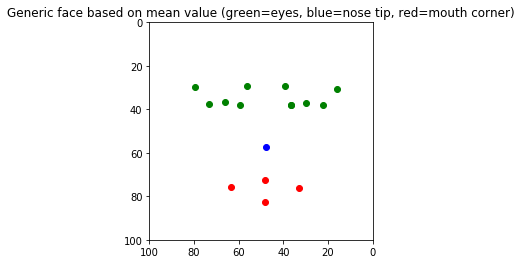

In [0]:
plt.figure(figsize=(4,4))
plt.subplot(1,1,1)
plt.title("Generic face based on mean value (green=eyes, blue=nose tip, red=mouth corner)")
plt.plot(means['right_eye_inner_corner_x'], means['right_eye_inner_corner_y'], 'go')
plt.plot(means['left_eye_center_x'], means['left_eye_center_y'], 'go')
plt.plot(means['right_eye_center_x'], means['right_eye_center_y'], 'go')
plt.plot(means['left_eye_inner_corner_x'], means['left_eye_inner_corner_y'], 'go')
plt.plot(means['left_eye_outer_corner_x'], means['left_eye_outer_corner_y'], 'go')
plt.plot(means['right_eye_inner_corner_x'], means['right_eye_inner_corner_y'], 'go')
plt.plot(means['right_eye_outer_corner_x'], means['right_eye_outer_corner_y'], 'go')
plt.plot(means['left_eyebrow_inner_end_x'], means['left_eyebrow_inner_end_y'], 'go')
plt.plot(means['left_eyebrow_outer_end_x'], means['left_eyebrow_outer_end_y'], 'go')
plt.plot(means['right_eyebrow_inner_end_x'], means['right_eyebrow_inner_end_y'], 'go')
plt.plot(means['right_eyebrow_outer_end_x'], means['right_eyebrow_outer_end_y'], 'go')
plt.plot(means['nose_tip_x'], means['nose_tip_y'], 'bo')
plt.plot(means['mouth_left_corner_x'], means['mouth_left_corner_y'], 'ro')
plt.plot(means['mouth_right_corner_x'], means['mouth_right_corner_y'], 'ro')
plt.plot(means['mouth_center_top_lip_x'], means['mouth_center_top_lip_y'], 'ro')
plt.plot(means['mouth_center_bottom_lip_x'], means['mouth_center_bottom_lip_y'], 'ro')
plt.ylim(0, 100)
plt.xlim(100, 0)
plt.gca().invert_yaxis()
pass

## 'Mean face' baseline (RMSE)

In [0]:
means_matrix = pd.DataFrame(np.ones((y_train.shape))) * np.array(means) 
rmse = np.sqrt(mean_squared_error(y_train, means_matrix))

print("Root mean square error of 'means baseline':", rmse)

Root mean square error of 'means baseline': 3.190696742439439


# Model training

## Convert data into appropriate shape for model training

In [0]:
# Converts pandas series into numpy array in appropriate shape
def convert_to_numpy(X):
    X = X.values
    imag = []
    for i in range(0, len(X)):
        imag.append(X[i])
    image_list = np.array(imag, dtype='float')
    X_new = image_list.reshape(-1,96,96,1)
    return X_new

  
# reset train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)


X_train = convert_to_numpy(X_train)
print("Shape of X_train (instances, height, width, channels): {}".format(X_train.shape))
X_test = convert_to_numpy(X_test)
print("Shape of X_test (instances, height, width, channels): {}".format(X_test.shape))

Shape of X_train (instances, height, width, channels): (1819, 96, 96, 1)
Shape of X_test (instances, height, width, channels): (321, 96, 96, 1)


## General considerations for model configuration

- Dataset with high dimensionality (image data): use a neural network with convolutional layers
- Regression problem (estimating x/y pixel values), therefore no need to have softmax (multiclass) as output layer
- Gather ideas from best-practice research on existing convolutional neural networks (e.g. VGG)

## Model 1 - Focus on efficiency (low/medium number of parameters)

- We create a neural network loosely modeled after `LeNet5`, probably the most widely known CNN architecture, created by Yann Le-Cun in 1998.
  - Our model features 4 `convolutional layers` and 2 `fully-connected layers`. The number of units in each layer is scaled according to the image size (LeNet: 32x32 pixel, Facial Keypoints 96x96 px).
  - The convolutional layers essentially convert the input image to a set of new features.  The inital convolutional layers convert the pixel values in their receptive fields (e.g. 5*5 pixel feature maps in the first layer) into simple features, which are then combined and converted into more complex representations.
  - The final representations are then fed to the 2 dense layers to finish the inference and generate the estimates of the facial keypoints.
- We use `elu` (exponential linear unit) as activation function (LeNet used `tanh`): 
$$ELU_\alpha(z)= \cases{\alpha(exp(z)-1) &if $z<0$\\z &if $z\geq{0}$}$$ 
  - `elu` creates small outputs for $z<0$, resulting in a non-zero gradient.  This helps to avoid the 'dying neuron problem' (i.e. neurons stop outputting anything else than '0'). 
  - The hyperparameter $\alpha$ defines the value that elu approaches for very large negative inputs - usually set to 1). 
  - `elu` does not saturate for positive values (similar to ReLu)
  - `elu` function is smooth everywhere, incl. $z=0$, which supports convergence. While `elu` is slower to compute than ReLu, it converges faster.
- We place a `Batch Normalization function` (zero-centering and normalizing the inputs) directly before the activation function (to avoid extremely large / small values --> vanishing / exploding gradient problem)
- We apply `average pooling layers` directly after each activation function. Pooling down-samples the feature maps to make them more invariant to the location of features in the image.
- We apply `dropout` as a regularization technique twice, close to the ouput layer.
- We select `adam optimization` (adaptive moment estimation) - it keeps track of an exponentially decaying average of past gradients and past squared gradients. Through this decay hyperparameter it is an adaptive learning rate algorithm and easier to configure than stochastic gradient descent.
- We choose a small `batch size` of '80' to increase speed (basic heuristic: use <10% of dataset size for batch size definition)


In [0]:
# loosely modeled after LeNet-5, scaled to image pixel size
model_1 = Sequential()

# input layer
model_1.add(Convolution2D(18, (5,5), padding='same', use_bias=False, input_shape=(96,96,1)))
model_1.add(BatchNormalization())
model_1.add(Activation('elu'))
model_1.add(AveragePooling2D(pool_size=(2, 2)))

model_1.add(Convolution2D(48, (5,5), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('elu'))
model_1.add(AveragePooling2D(pool_size=(2, 2)))

model_1.add(Convolution2D(360, (5,5), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('elu'))
model_1.add(AveragePooling2D(pool_size=(2, 2)))

model_1.add(Convolution2D(360, (5,5), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('elu'))
model_1.add(AveragePooling2D(pool_size=(2, 2)))

model_1.add(Flatten())
model_1.add(Dense(252,activation='elu'))
model_1.add(Dropout(0.5))

# output layer (30 values to estimate)
model_1.add(Dense(30))

W0820 20:33:52.159701 140144117065600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 20:33:52.163253 140144117065600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 20:33:52.174051 140144117065600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 20:33:52.216084 140144117065600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0820 20:33:52.216957 1401441170

In [0]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 18)        450       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 18)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 18)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 48, 48, 18)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 48)        21648     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 48)        192       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 48)        0         
__________

In model 1, the non-trainable parameters include the mean and standard deviation values computed in the `Batch Normalization` layers of the model.

In [0]:
opt= 'adam'

model_1.compile(optimizer=opt, 
              loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])

W0820 20:33:55.770154 140144117065600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model_1_history = model_1.fit(X_train, y_train, epochs = 50, batch_size = 80, validation_data=(X_test, y_test))

Train on 1819 samples, validate on 321 samples
Epoch 1/50
1819/1819 [==============================] - 8s 4ms/step - loss: 642.2695 - mean_squared_error: 642.2695 - mean_absolute_error: 19.6214 - val_loss: 667.4130 - val_mean_squared_error: 667.4130 - val_mean_absolute_error: 17.3673
Epoch 2/50
1819/1819 [==============================] - 2s 895us/step - loss: 197.6665 - mean_squared_error: 197.6665 - mean_absolute_error: 11.1560 - val_loss: 118.1745 - val_mean_squared_error: 118.1745 - val_mean_absolute_error: 7.4953
Epoch 3/50
1819/1819 [==============================] - 2s 892us/step - loss: 142.4214 - mean_squared_error: 142.4214 - mean_absolute_error: 9.4209 - val_loss: 55.8498 - val_mean_squared_error: 55.8498 - val_mean_absolute_error: 5.2816
Epoch 4/50
1819/1819 [==============================] - 2s 896us/step - loss: 118.1757 - mean_squared_error: 118.1757 - mean_absolute_error: 8.5690 - val_loss: 16.5992 - val_mean_squared_error: 16.5992 - val_mean_absolute_error: 3.1126
Epoc

## Model 2 - Focus on complex representation (high number of parameters)

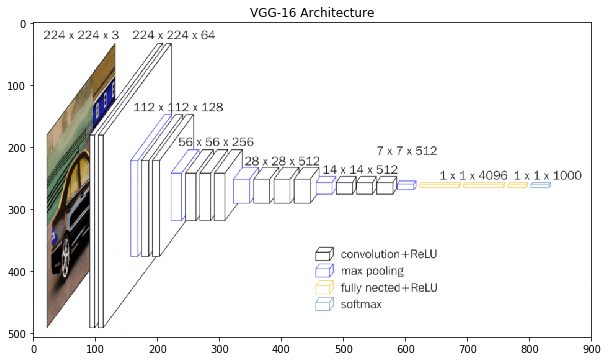

In [0]:
import cv2
FVGG = path + 'data/vgg16-arch.png'
img = cv2.imread(FVGG)
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title("VGG-16 Architecture")
plt.imshow(img)
plt.show()



* Modelled after VGG16
* The input layer is the size of the 96 x 96 B&W image
* The image is passed through a stack of convolutional layers, where the filters were used with a convolution field of 3×3
* Though small 3x3 is is still able to capture the notion of left/right, up/down, center.
* The convolution stride is 1 pixel and the padding used is "same".
* Spatial pooling is carried out by five max-pooling layers, which follow the convolutional layers. We use MaxPooling instead of AveragePooling (model 1)
* Max-pooling is performed over a 2×2 pixel window, with stride 2.
* Each layer add an additional 2x number of feature maps going from 64 to 128 to 256 to 512 to 1024, which the dimensions of the feature maps after max_pooling go from 48 to 24 to 12 to 6 to 3.
* Two Fully-Connected (FC) layers follow a stack of convolutional layers: the first has 4096 outputs and the second has 30 to match the 30 keypoints the model is detecting.
* All hidden layers are equipped with the eLU non-linearity



In [0]:
model_2 = Sequential()

model_2.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model_2.add(Activation('elu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Convolution2D(128, (3,3), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Convolution2D(256, (3,3), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Convolution2D(512, (3,3), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Convolution2D(1024, (3,3), padding='same'))
model_2.add(Activation('elu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())
model_2.add(Dense(4096))
model_2.add(Dense(30))

W0820 20:35:27.465534 140144117065600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [0]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 96, 64)        576       
_________________________________________________________________
activation_5 (Activation)    (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 256)       295168    
__________

In [0]:
opt= 'adam'

model_2.compile(optimizer=opt, 
              loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'accuracy'])

In [0]:
model_2_history = model_2.fit(X_train, y_train, epochs = 50, batch_size = 80, validation_data=(X_test, y_test))

Train on 1819 samples, validate on 321 samples
Epoch 1/50
1819/1819 [==============================] - 8s 4ms/step - loss: 2029.7135 - mean_squared_error: 2029.7135 - mean_absolute_error: 30.0180 - acc: 0.3101 - val_loss: 202.4574 - val_mean_squared_error: 202.4574 - val_mean_absolute_error: 11.8363 - val_acc: 0.7072
Epoch 2/50
1819/1819 [==============================] - 3s 1ms/step - loss: 123.3652 - mean_squared_error: 123.3652 - mean_absolute_error: 8.1858 - acc: 0.5410 - val_loss: 56.0951 - val_mean_squared_error: 56.0951 - val_mean_absolute_error: 5.5046 - val_acc: 0.6604
Epoch 3/50
1819/1819 [==============================] - 3s 1ms/step - loss: 31.2338 - mean_squared_error: 31.2338 - mean_absolute_error: 4.1043 - acc: 0.6542 - val_loss: 17.1566 - val_mean_squared_error: 17.1566 - val_mean_absolute_error: 3.0933 - val_acc: 0.6698
Epoch 4/50
1819/1819 [==============================] - 3s 1ms/step - loss: 15.6001 - mean_squared_error: 15.6001 - mean_absolute_error: 2.9124 - acc: 

# Test models

## Metric: RMSE

### Model 1 RMSE

In [0]:
y_pred_train = model_1.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Root mean square error of model 1 on train data set:", rmse)

Root mean square error of model 1 on train data set: 3.3080941882459833


In [0]:
y_pred_test = model_1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Root mean square error of model 1 on test data set:", rmse)

Root mean square error of model 1 on test data set: 3.2719432259893377


In [0]:
# alternative code for getting the rmse from the model
rmse = np.sqrt(model_1.evaluate(X_test, y_test)[0])
rmse

321/321 [==============================] - 0s 367us/step


3.2719432404674187

### Model 2 RMSE

In [0]:
y_pred_train = model_2.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Root mean square error of model 2 on train data set:", rmse)

Root mean square error of model 2 on train data set: 2.5292580834226004


In [0]:
y_pred_test = model_2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Root mean square error of model 2 on test data set:", rmse)

Root mean square error of model 2 on test data set: 2.6588636023741286


Intermediate finding: Model 2 scores better on the RMSE metric than model 1 both for the training and test data set. For both models, the RMSE metric between train and test set does not differ significantly, implying that the models are probably not overfitting on the training data.

## Metrices by training epoch

### Loss - model comparison

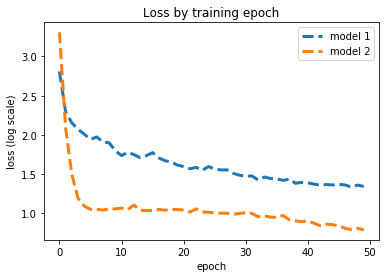

In [0]:
def plot_loss(hist, label):
  loss = np.log10(hist['loss'])
  plt.plot(loss, "--", linewidth=3, label=label)
  plt.title("Loss by training epoch")
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("loss (log scale)")
  

plot_loss(model_1_history.history, "model 1")
plot_loss(model_2_history.history, "model 2")

For both models, we have a continuously decreasing loss gradient, with a steep negative slope in the first few epochs. We will look at the optimal stopping epoch at a later stage of the analysis.

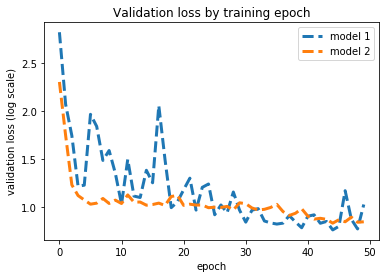

In [0]:
def plot_val_loss(hist, label):
  val_loss = np.log10(hist['val_loss'])
  plt.plot(val_loss, "--", linewidth=3, label=label)
  plt.title("Validation loss by training epoch")
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("validation loss (log scale)")
  

plot_val_loss(model_1_history.history, "model 1")
plot_val_loss(model_2_history.history, "model 2")

Validation loss is fluctuating stronger in model 1.

### RMSE - model comparison

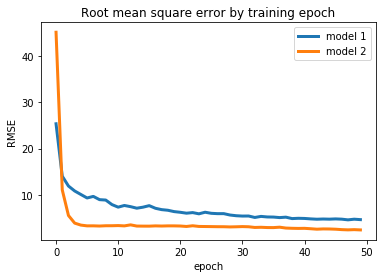

In [0]:
def plot_rmse(hist, label):
  rmse = np.sqrt(hist['mean_squared_error'])
  plt.plot(rmse, linewidth=3, label=label)
  plt.title("Root mean square error by training epoch")
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("RMSE")

plot_rmse(model_1_history.history, "model 1")
plot_rmse(model_2_history.history, "model 2")

### Finding optimal training epoch

In [0]:
def plot_loss(hist, title):
  loss = np.log10(hist['loss'])
  val_loss = np.log10(hist['val_loss'])
  plt.plot(loss, "--", linewidth=3, label='loss')
  plt.plot(val_loss, "--", linewidth=3, label='validation loss')
  plt.title(title)
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("loss (log scale)")

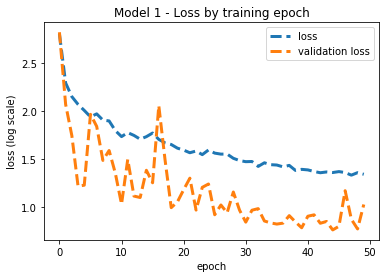

In [0]:
plot_loss(model_1_history.history, "Model 1 - Loss by training epoch")

Model 1 could still be underfitting after 100 epochs (validation loss << training loss). An alternative explanation could be that the training data contains difficult cases which increase the RMSE.

In [0]:
min_epoch = np.argmin(model_1_history.history['val_loss']) + 1
print("Model 1: minimum validation loss reached in epoch {}".format(min_epoch))

Model 1: minimum validation loss reached in epoch 45


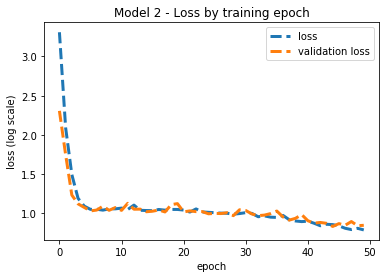

In [0]:
plot_loss(model_2_history.history, "Model 2 - Loss by training epoch")

Model 2 seems to be well calibrated (neither under- nor overfitting).

In [0]:
min_epoch = np.argmin(model_2_history.history['val_loss']) + 1
print("Model 2: minimum validation loss reached in epoch {}".format(min_epoch))

Model 2: minimum validation loss reached in epoch 45


## Model interpretation

### Model 1 on training data

In [0]:
# plot best and worst cases
def predicted_faces(model, xdata, ydata, best, num_faces):
    '''
    This function computes rmse for each case based on model, xdata and ydata,
    selects the best/worst faces based on rmse and 
    prints out faces    
    '''
    # prediction 
    y_pred = model.predict(xdata)
    # convert y_pred to dataframe
    df_y_pred = pd.DataFrame(y_pred, index = range(len(xdata)), columns=ydata.columns)
    # reset index for y train
    ydata.index = range(len(xdata))
    # compute mean squared error for each row 
    rmse_i = np.sqrt(np.mean((ydata - y_pred)**2, axis = 1))
    # convert rmse to dataframe
    df_rmse = pd.DataFrame(rmse_i, columns=['rmse'])
    
    if best == True:
        face = df_rmse.nsmallest(num_faces, 'rmse')        
    else:
        face = df_rmse.nlargest(num_faces, 'rmse')        

    face_ids = face.index 
    images = xdata[face_ids]        
    keypoints_train = ydata.loc[face_ids]
    keypoints_pred = df_y_pred.loc[face_ids]
    # create a list keypoint columns 
    keypoint_cols = list(ydata.columns)   
    
    fig, axs = plt.subplots(figsize=(10,10), nrows=num_faces, ncols=2)
    if best == True:
        fig.suptitle('Best Predictions',  fontsize=16) 
    else:
        fig.suptitle('Worst Predictions',  fontsize=16) 
        
    
    image_ind = 0
    for i in range(num_faces):
        xy_train = keypoints_train.iloc[image_ind][keypoint_cols].values.reshape((15,2))
        xy_pred = keypoints_pred.iloc[image_ind][keypoint_cols].values.reshape((15,2))        
        image = images[image_ind].reshape(96,96)        
        axs[i, 0].imshow(image, interpolation="nearest", cmap="gray")
        axs[i, 0].plot(xy_train[:, 0], xy_train[:, 1], 'bo')
        axs[i, 0].set_title("Picture Row Number = {}".format(face_ids[i]))
        axs[i, 0].axis('off')
        axs[i, 1].imshow(image, interpolation="nearest", cmap="gray")
        axs[i, 1].plot(xy_pred[:, 0], xy_pred[:, 1], 'ro')
        axs[i, 1].set_title("Prediction (RMSE = {})".format(face.iloc[image_ind].values))
        axs[i, 1].axis('off')
    
        
        image_ind +=1    

#### Print Best Predicted Three Images : Model 1

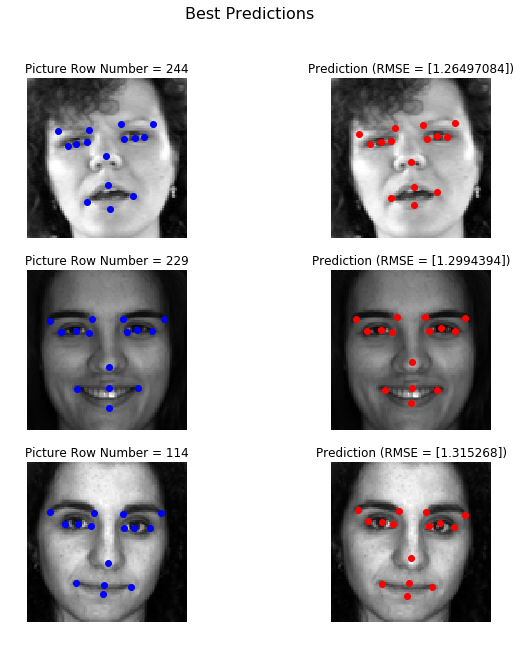

In [0]:
predicted_faces(model_1, X_test, y_test, True, 3)

#### Print Worst Predicted Three Images : Model 1

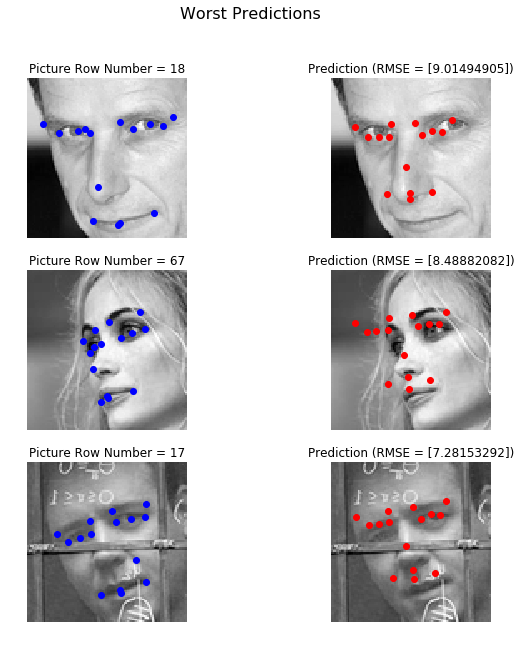

In [0]:
predicted_faces(model_1, X_test, y_test, False, 3)

### Model 2 on training data

#### Print Best Predicted Three Images : Model 2

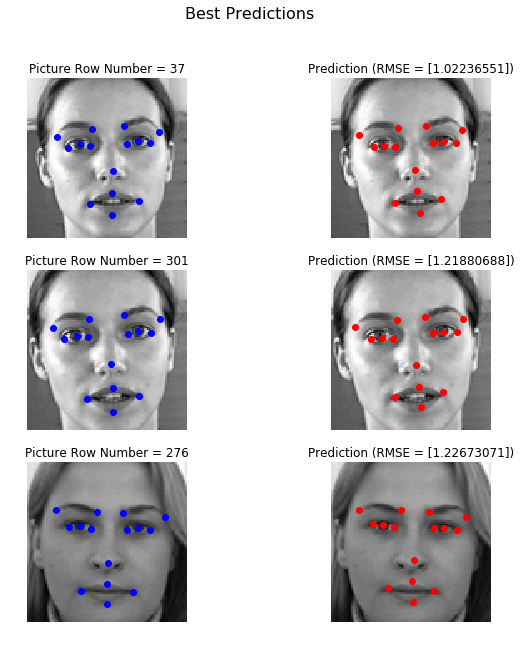

In [0]:
predicted_faces(model_2, X_test, y_test, True, 3)

#### Print Best Predicted Three Faces : Model 2

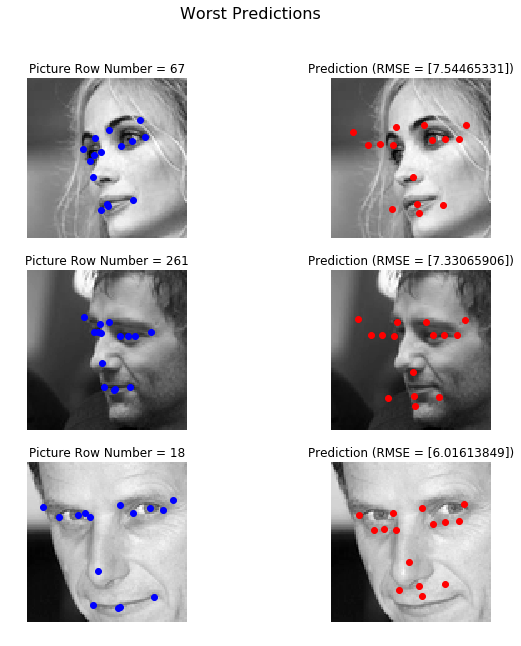

In [0]:
predicted_faces(model_2, X_test, y_test, False, 3)

Intermediate finding: it is interesting to see that the model copes well with frontal facial views, while varying head poses and glasses seem to cause problems (occlusion of eye features as a possible cause). 

# Improving model performance

## Data augmentation


We need more training data! Due to missing labels, dataset with no missing labels is approximately 1800 entries, which is very small. We tried two augmentation techniques for improving model performance.

1.   Flipping Image to generate additional inputs
2.   Prediction to replace missing values

Example of our code to flip images is below.  During training the model would "lose it's way" and it's loss would increase dramatically.  It would never be able to fully recover and in the end the RMSE was higher than with the model without the "flipped" data. Recommended to add "batch normalization" to help avoid exploding gradients.

We created another notebook for (2) called [Data Augmentation - Fill-in Missing Values](https://drive.google.com/open?id=1QdcyObMzkR-8j-R5aYNAtnEKUE3EtpU3). With getting "lucky" with the model training, we were able to now leverage the full dataset.  The final RMSE was 1.81, again higher than the model that does not use the extra data.  However, when submitted to Kaggle using their test data, the RMSE for the model using the subset of data (no missing labels) was 3.56, while it was 2.61 using the full training set with interpolated labels.



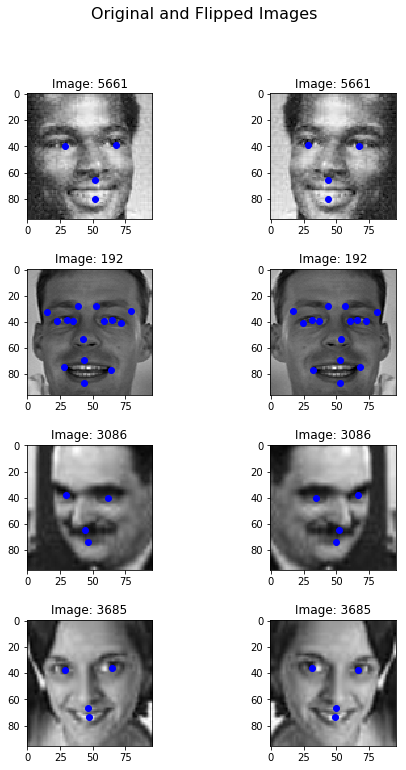

In [0]:
def flipper(image, labels):
    features = ['left_eye_center_x', 'right_eye_center_x', 'left_eye_inner_corner_x', 'left_eye_outer_corner_x',
                'right_eye_inner_corner_x', 'right_eye_outer_corner_x', 'left_eyebrow_inner_end_x',
                'left_eyebrow_outer_end_x', 'right_eyebrow_inner_end_x', 'right_eyebrow_outer_end_x', 'nose_tip_x',
                'mouth_left_corner_x', 'mouth_right_corner_x', 'mouth_center_top_lip_x', 'mouth_center_bottom_lip_x']
    f_image = image[:, ::-1]
    f_labels = labels.copy(deep=True)
    
    for l in features:
      f_labels[l] = 96 - f_labels[l]

    # plt.figure(figsize=(8,8))
    # plt.subplot(1,2,1)
    # plt.title("Sample image")
    # plt.imshow(X_train[8].reshape(96,96), interpolation="nearest", cmap="gray")
    # plt.subplot(1,2,2)
    # plt.title("Sample flip")
    # plt.imshow(f_image.reshape(96,96), interpolation="nearest", cmap="gray")

    return f_image.reshape(96*96,), f_labels

def flip_data(X_train, y_train):
  num_images = len(X_train)
  X_train_f = X_train.copy(deep=True) 
  y_train_f = y_train.copy(deep=True)

  for i in range(num_images):
    X_train_f[i], y_train_f.loc[i] = flipper(X_train[i].reshape(96,96), y_train.loc[i])
    
  return X_train_f, y_train_f

def print_flipped_faces(X, y, X_f, y_f, nrows):   

  # select random sample  
  random_sample_ind = np.random.choice(y.index, size=nrows, replace=False)
  images = X[random_sample_ind]
  images_f = X_f[random_sample_ind]
  keypoints = y.loc[random_sample_ind]
  keypoints_f = y_f.loc[random_sample_ind]

  # create a list keypoint columns 
  keypoint_cols = list(y.columns) 
  keypoint_cols_f = list(y_f.columns)   

  # create plots
  fig, axs = plt.subplots(figsize=(8,12), nrows=nrows, ncols=2)
  image_ind = 0
  for i in range(nrows):
    # plot original image
    xy = keypoints.iloc[image_ind][keypoint_cols].values.reshape((15,2))            
    image = images.iloc[image_ind].reshape(96,96)
    axs[i, 0].imshow(image, interpolation="nearest", cmap="gray")
    axs[i, 0].plot(xy[:, 0], xy[:, 1], 'bo')
    axs[i, 0].set_title("Image: " + str(random_sample_ind[image_ind]))

    
    # plot flipped image
    xy_f = keypoints_f.iloc[image_ind][keypoint_cols_f].values.reshape((15,2))            
    image_f = images_f.iloc[image_ind].reshape(96,96)
    axs[i, 1].imshow(image_f, interpolation="nearest", cmap="gray")
    axs[i, 1].plot(xy_f[:, 0], xy_f[:, 1], 'bo')
    axs[i, 1].set_title("Image: " + str(random_sample_ind[image_ind]))
    image_ind += 1
  
  fig.suptitle("Original and Flipped Images", fontsize=16)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

# Reload Data
X_train, y_train = load(train=True, drop_missing=False)
X_test, y_test = load(train=False, drop_missing=True)

# Create flipped images
X_train_f, y_train_f = flip_data(X_train, y_train)

# Show original and flipped images
print_flipped_faces(X_train, y_train, X_train_f, y_train_f, 4)



# Visualizing intermediate activations of CNN layers

## Example image

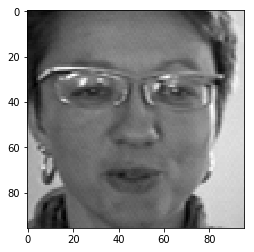

In [0]:
plt.imshow(X_train[62].reshape(96,96), cmap='gray')
pass

## Model 1 - CNN activations

In [0]:
model = model_1

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[62].reshape(1,96,96,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
           

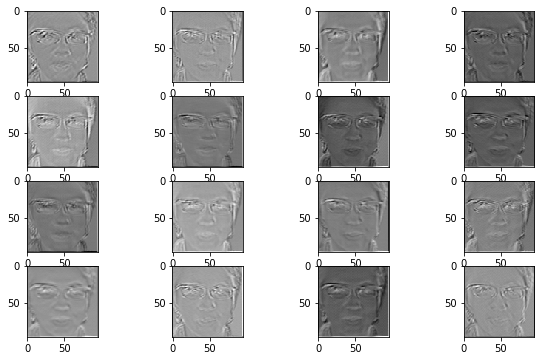

In [0]:
# First layer
display_activation(activations, 4, 4, 0)

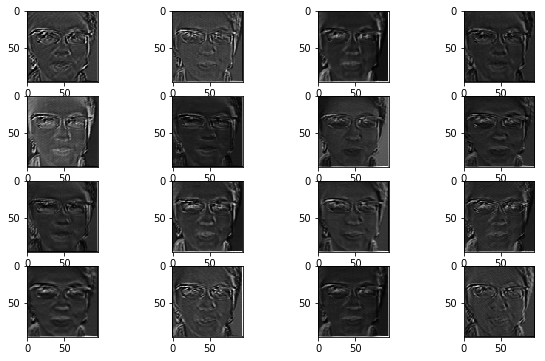

In [0]:
# Third layer
display_activation(activations, 4, 4, 2)

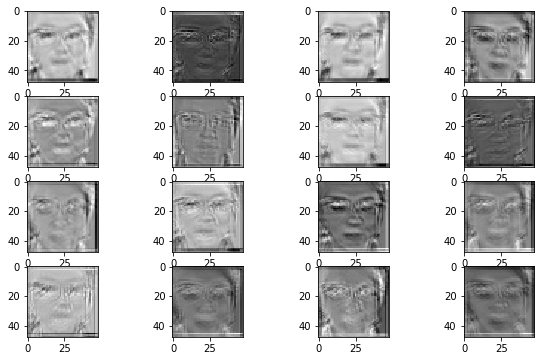

In [0]:
# Fifth layer
display_activation(activations, 4, 4, 4)

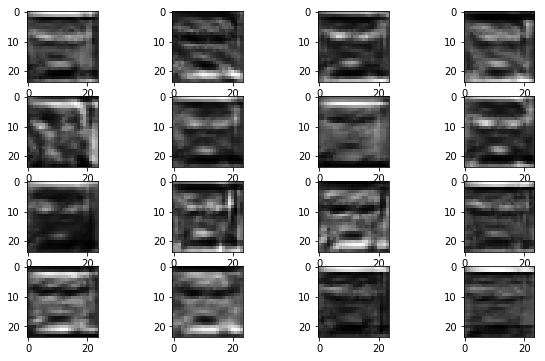

In [0]:
# Eleventh layer
display_activation(activations, 4, 4, 10)

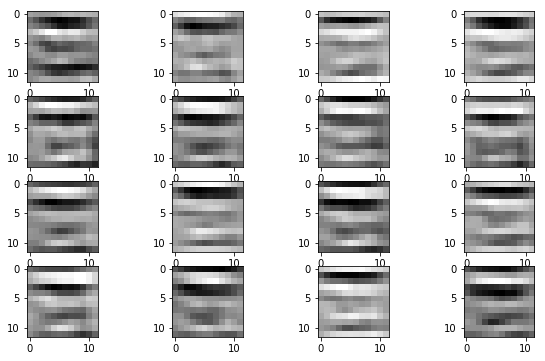

In [0]:
# Thirteenth layer
display_activation(activations, 4, 4, 12)

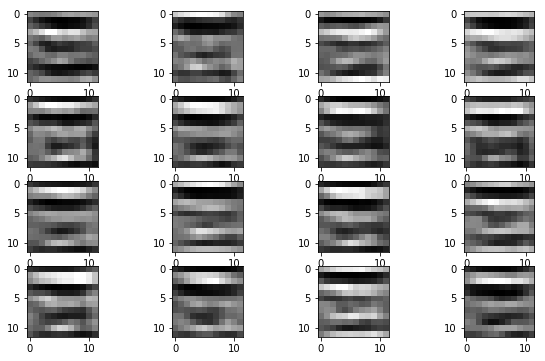

In [0]:
# Fifteenth layer
display_activation(activations, 4, 4, 14)

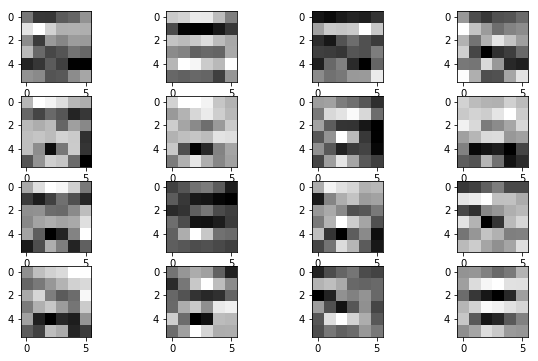

In [0]:
# Sixteenth layer
display_activation(activations, 4, 4, 15)

## Model 2 - CNN activations

In [0]:
model = model_2

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[62].reshape(1,96,96,1))
 

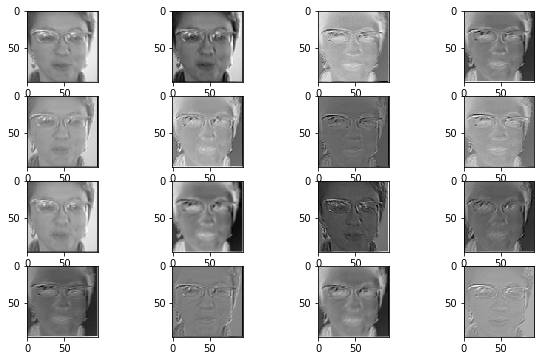

In [0]:
# First layer
display_activation(activations, 4, 4, 0)

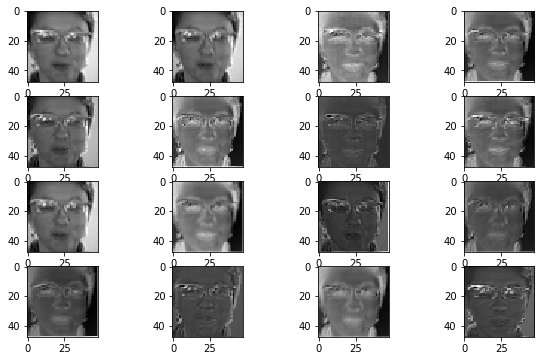

In [0]:
# Third layer
display_activation(activations, 4, 4, 2)

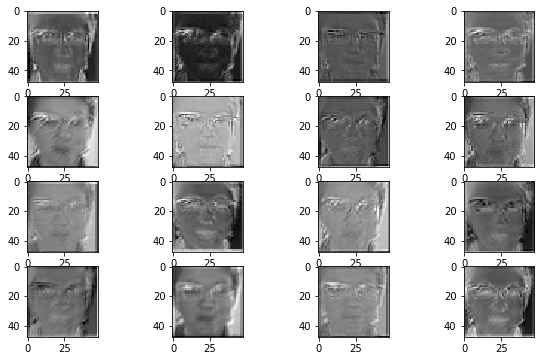

In [0]:
# Fifth layer
display_activation(activations, 4, 4, 4)

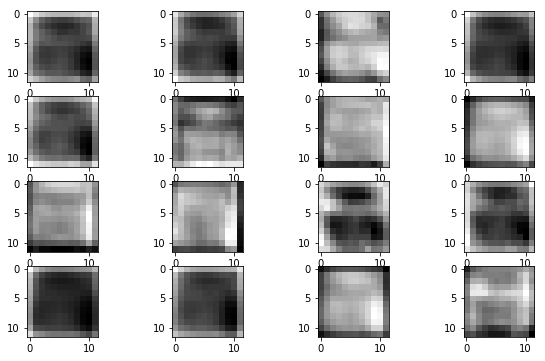

In [0]:
# Eleventh layer
display_activation(activations, 4, 4, 10)

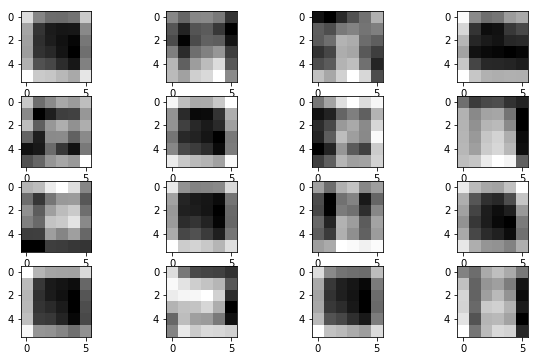

In [0]:
# Thirteenth layer
display_activation(activations, 4, 4, 12)

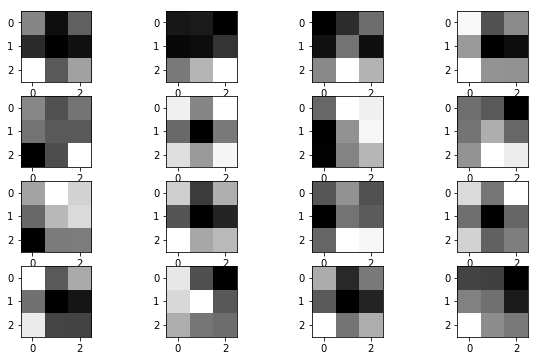

In [0]:
# Fifteenth layer
display_activation(activations, 4, 4, 14)

# Summary and Discussion 



  * From the EDA we found that there seem to be significant issues with the quality of the ground truth, as some feature locations appear to be mislabeled. This might place an upper limit on the achievable metrics for this machine learning task
  * Difficult to find the right configuration for the neural network (large hyperparameter search space). Example: Not clear whether number of neurons/units should increase or decrease in the upper layers (literature seems to be split in this question).
  * Nevertheless we were able to build two models with decent performance, measured by RMSE of predicted facial feature positions. With model 2, we were able to beat our mean-value calculated baseline (RMSE ca. 3.2) by a large margin (RMSE of model 2 ca. 2).
  * We built our models based on some 'heuristics' which we derived from the literature (usage of regularization techniques, selection of elu as activation to counter vanishing gradients, convolutional layers followed by dense layers, etc.)
  * Both our models had similar scores both on the training as well as on the test set, implying that overfitting does not seem to be an issue.
  * Varying head poses and occlusions cause problems in detecting facial keypoints. Improving the model further requires more training data for these corner cases.
  * Data augmentation did not yield much with regard to metric improvement.
  * Top 20 place in Kaggle Competition with limited # of epochs used for training.